# Inference with sampling for flu data

## Flu case incidences

In [44]:
import numpy as np
import pandas as pd

import seirmo as se
from seirmo import plots

# read french flu data
flu_data = se.DatasetLibrary().french_flu()

# extract data of roughly one season (estimated)
flu_data = flu_data.loc[:30,:]
times = flu_data['time_index']

# normalise incidence number by its maximum
flu_data['inc'] = flu_data['inc'] #/ np.max(flu_data['inc'])

In [45]:
# Plot incidences data
plot = plots.IncidenceNumberPlot()
plot.add_data(flu_data, time_key='time_index', inc_key='inc')
plot.show()

# Using pints

In [46]:
import pints

class SEIRModel(pints.ForwardModel):
    def __init__(self):
        super(SEIRModel, self).__init__()

        self._model = se.SEIRModel()
    
    def n_outputs(self):
        # Returns number of model outputs.
        # Returns only incidence number, in line with the flu data
        return 1

    def n_parameters(self):
        # Returns number of parameters, i.e. 4 initial condition and 3 parameters.
        return 7
    
    def simulate(self, parameters, times):
        # parameters = np.exp(log_parameters)
        output = self._model.simulate(parameters=parameters, times=times, return_incidence=True)
        n_incidence = output[:,4]

        return n_incidence

In [47]:
# Create log-likelihood
pints_model = SEIRModel()
problem = pints.SingleOutputProblem(pints_model, times, flu_data['inc'])
log_likelihood = pints.GaussianLogLikelihood(problem)

In [48]:
log_prior = pints.ComposedLogPrior(
    pints.GaussianLogPrior(0, 0.1),
    pints.GaussianLogPrior(0, 0.1),
    pints.GaussianLogPrior(0, 0.1),
    pints.GaussianLogPrior(0, 0.1),
    pints.GaussianLogPrior(0, 0.1),
    pints.GaussianLogPrior(0, 0.1),
    pints.GaussianLogPrior(0, 0.1),
    pints.GaussianLogPrior(0, 0.1)
)


In [49]:
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

In [50]:
# initial parameter guess
# parameter_guess = np.log(np.array([0.7, 0.5, 0.5, 0.5, 0.5, 0.5, 0.1, 0.1]))

In [51]:
xs = log_prior.sample(3)

In [42]:
# parameter transformation
transform = pints.LogTransformation(n_parameters=8)
mcmc = pints.MCMCController(log_posterior, 3, [xs[2], xs[2], xs[2]], method=pints.HaarioBardenetACMC, transform=transform)
# mcmc = pints.MCMCController(log_posterior, 3, xs, method=pints.HaarioBardenetACMC, transform=transform)

# mcmc.set_max_iterations(4000)

chains = mcmc.run()

Using Haario-Bardenet adaptive covariance MCMC
Generating 3 chains.
Running in sequential mode.


KeyboardInterrupt: 

# Pints' diagnostic plots

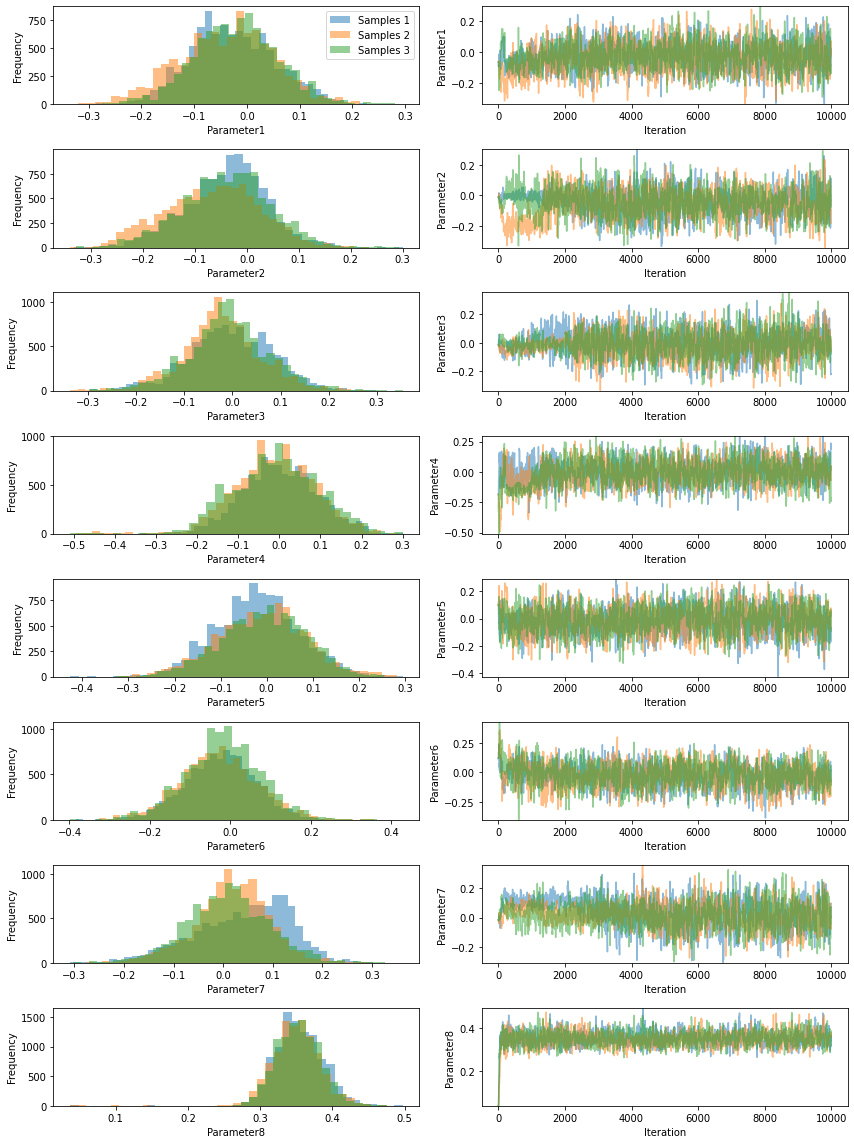

In [70]:
import pints.plot
import matplotlib.pyplot as plt

pints.plot.trace(chains)
plt.show()

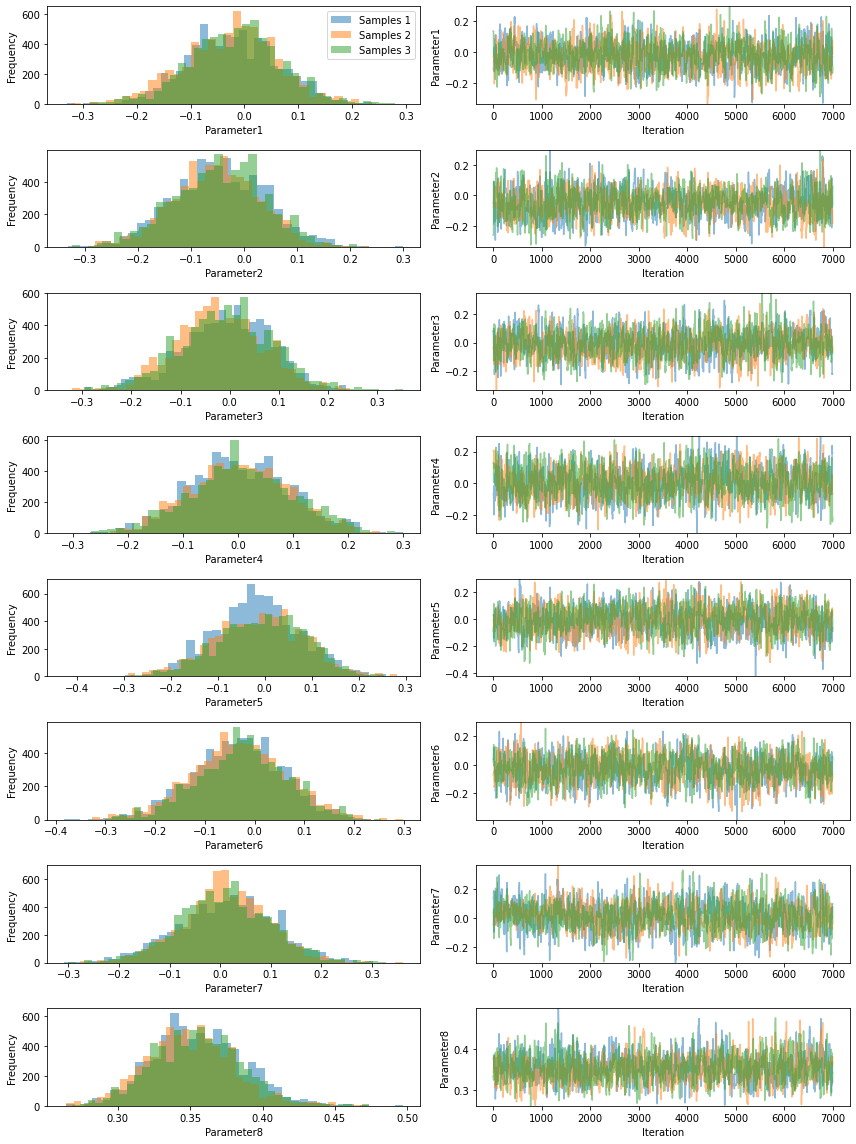

In [72]:
pints.plot.trace(chains[:, 3000:, :])
plt.show()